# NLP Notebook

## Libraries import

In [4]:
import os

os.chdir('..')

In [6]:
from streamlite.Products_database import ProductDatabase
from streamlite.shopping import ShoppingCart

import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from collections import Counter
import re
from itertools import chain
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from scipy.stats import chi2_contingency
from nltk.util import ngrams

## Data exploration

In [11]:
json_file = "data/final_extracted_products.json"

In [12]:
f = open(json_file)
json_data = json.load(f)

In [7]:
unique_ingredients_analysis_tags = set()

for product_id, product_data in tqdm(json_data.items()):
    tags = product_data.get('ingredients_analysis_tags', None)
    if tags:
        unique_ingredients_analysis_tags.update(tags)

# Displaying the unique values
unique_ingredients_analysis_tags

100%|██████████| 9949/9949 [00:00<00:00, 63931.82it/s]


{'en:may-contain-palm-oil',
 'en:maybe-vegan',
 'en:maybe-vegetarian',
 'en:non-vegan',
 'en:non-vegetarian',
 'en:palm-oil',
 'en:palm-oil-content-unknown',
 'en:palm-oil-free',
 'en:vegan',
 'en:vegan-status-unknown',
 'en:vegetarian',
 'en:vegetarian-status-unknown'}

In [9]:
nb_product_without_tags = 0
nb_product_unknow_tags = 0

for product_id, product_data in tqdm(json_data.items()):
    tags = product_data.get('ingredients_analysis_tags', None)
    if not tags:
        nb_product_without_tags += 1
    elif 'en:vegetarian-status-unknown' in tags or 'en:vegan-status-unknown' in tags:
        nb_product_unknow_tags += 1
# Displaying the unique values
print(f"\nThere are {nb_product_without_tags} product without vegan/vegetarian info")
print(f"\nThere are {nb_product_unknow_tags} product with vegan/vegetarian info unknwow")

100%|██████████| 9949/9949 [00:00<00:00, 67710.22it/s]


There are 496 product without vegan/vegetarian info

There are 3242 product with vegan/vegetarian info unknwow


In [11]:
# new_json = {}
# stop = 50

# for product_id, row in tqdm(json_data.items()):
#     new_json[product_id] = row
#     stop = stop - 1
#     if stop == -1:
#         break

# with open('json_data_50.json', 'w', encoding='utf-8') as file:
#      json.dump(new_json, file, ensure_ascii=False, indent=4)

  1%|          | 50/9949 [00:00<00:00, 259227.69it/s]


In [13]:
# Extract 'ingredients_tags' and 'labels_tags'
data = [{'id': product.get('_id'),
        'ingredients_tags': product.get('ingredients_tags', []), 
         'labels_tags': product.get('ingredients_analysis_tags', [])} 
        for product in json_data.values()]

# Create a DataFrame
df = pd.DataFrame(data)

In [25]:
df.head()

,id,ingredients_tags,labels_tags
0,3274080005003,"[en:spring-water, en:water]","[en:palm-oil-free, en:vegan, en:vegetarian]"
1,3017620422003,"[en:sugar, en:added-sugar, en:disaccharide, en...","[en:palm-oil, en:non-vegan, en:vegetarian-stat..."
2,7622210449283,"[en:cereal, en:sugar, en:added-sugar, en:disac...","[en:palm-oil, en:non-vegan, en:vegetarian-stat..."
3,5449000214911,"[en:carbonated-water, en:water, en:sugar, en:a...","[en:palm-oil-free, en:maybe-vegan, en:maybe-ve..."
4,3017620425035,"[en:sugar, en:added-sugar, en:disaccharide, en...","[en:palm-oil, en:non-vegan, en:vegetarian-stat..."


## Data cleaning

### removings unwanted words ('en:..' , 'fr:..')

In [20]:
# df.to_csv('path_to_file.csv', index=False)

In [50]:
def clean_tags(tags):
    # Remove 'en:' prefix and replace hyphens/underscores with spaces
    if tags:
        cleaned_tags = [re.sub(r"(en:|-|_)", " ", str(tag)).strip() for tag in tags if tag]
        return cleaned_tags
    return ['']

In [56]:
# Extract 'ingredients_tags' and 'labels_tags'
data = [{'id': product.get('_id'),
        'ingredients_tags': product.get('ingredients_tags', ['']), 
         'labels_tags': product.get('ingredients_analysis_tags', [''])} 
        for product in json_data.values()]

# Create a DataFrame
df = pd.DataFrame(data)

In [61]:
df['cleaned_ingredients'] = df['ingredients_tags'].apply(clean_tags)
df['cleaned_ingredients'] = df['cleaned_ingredients'].apply(lambda x: x.replace('fr:', '') if x else x)

In [84]:
df['clean_labels_tags'] = df['labels_tags'].apply(lambda x : [str(y.split(':')[-1].replace('-', ' ')) for y in ast.literal_eval(x) if y] if x else [''])

In [41]:
len(df)

9949

### removing products without ingredients

In [42]:
df = df[df['cleaned_ingredients'] != "['']"]
df = df.reset_index(drop=True)

In [43]:
len(df)

9436

## Data visualisation (data understanding)

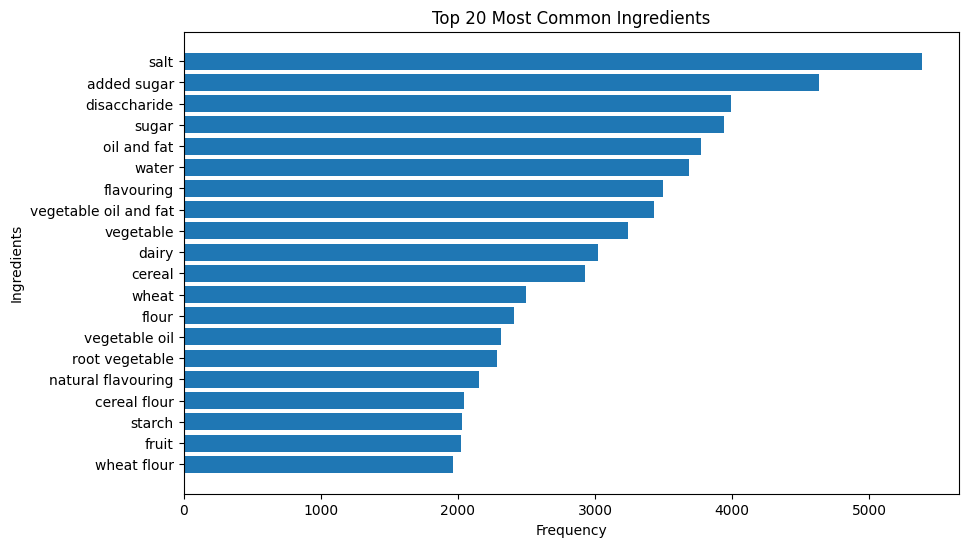

In [53]:
# Flatten the list of all ingredient tags to count the frequencies
all_ingredients = [ingredient for sublist in df['cleaned_ingredients'] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Display the most common ingredients
most_common_ingredients = ingredient_counts.most_common(20)

# Create a bar plot for the most common ingredients
plt.figure(figsize=(10, 6))
plt.barh([ingredient[0] for ingredient in most_common_ingredients], [ingredient[1] for ingredient in most_common_ingredients])
plt.xlabel('Frequency')
plt.ylabel('Ingredients')
plt.title('Top 20 Most Common Ingredients')
plt.gca().invert_yaxis() # To display the highest count at the top
plt.show()

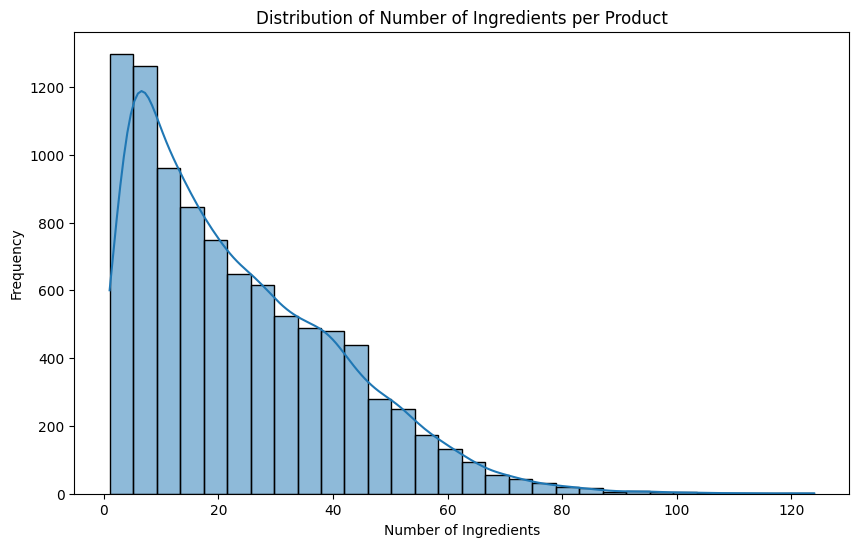

In [49]:
# Counting the number of ingredients in each product
df['num_ingredients'] = df['cleaned_ingredients'].apply(lambda x: len(ast.literal_eval(x)))

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['num_ingredients'], bins=30, kde=True)
plt.title('Distribution of Number of Ingredients per Product')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

In [58]:
# Create binary labels for 'Vegan' and 'Vegetarian'
df['Vegan'] = df['labels_tags'].apply(lambda tags: 1 if tags and 'en:vegan' in tags else 0)
df['Vegetarian'] = df['labels_tags'].apply(lambda tags: 1 if tags and 'en:vegetarian' in tags else 0)

In [62]:
df.head()

,id,ingredients_tags,labels_tags,Vegan,Vegetarian,cleaned_ingredients
0,3274080005003,"[en:spring-water, en:water]","[en:palm-oil-free, en:vegan, en:vegetarian]",1,1,"[spring water, water]"
1,3017620422003,"[en:sugar, en:added-sugar, en:disaccharide, en...","[en:palm-oil, en:non-vegan, en:vegetarian-stat...",0,0,"[sugar, added sugar, disaccharide, palm oil, o..."
2,7622210449283,"[en:cereal, en:sugar, en:added-sugar, en:disac...","[en:palm-oil, en:non-vegan, en:vegetarian-stat...",0,0,"[cereal, sugar, added sugar, disaccharide, pal..."
3,5449000214911,"[en:carbonated-water, en:water, en:sugar, en:a...","[en:palm-oil-free, en:maybe-vegan, en:maybe-ve...",0,0,"[carbonated water, water, sugar, added sugar, ..."
4,3017620425035,"[en:sugar, en:added-sugar, en:disaccharide, en...","[en:palm-oil, en:non-vegan, en:vegetarian-stat...",0,0,"[sugar, added sugar, disaccharide, palm oil, o..."


In [63]:
# Separate the dataset into vegan, non-vegan, vegetarian, and non-vegetarian groups
vegan_products = df[df['Vegan'] == 1]['cleaned_ingredients']
non_vegan_products = df[df['Vegan'] == 0]['cleaned_ingredients']
vegetarian_products = df[df['Vegetarian'] == 1]['cleaned_ingredients']
non_vegetarian_products = df[df['Vegetarian'] == 0]['cleaned_ingredients']

# Function to count ingredient frequencies in a given dataset
def count_ingredients(dataset):
    all_ingredients = [ingredient for sublist in dataset for ingredient in sublist]
    return Counter(all_ingredients)

# Count the ingredient frequencies for each group
vegan_ingredient_counts = count_ingredients(vegan_products)
non_vegan_ingredient_counts = count_ingredients(non_vegan_products)
vegetarian_ingredient_counts = count_ingredients(vegetarian_products)
non_vegetarian_ingredient_counts = count_ingredients(non_vegetarian_products)

# Display the most common ingredients in each group
most_common_vegan = vegan_ingredient_counts.most_common(10)
most_common_non_vegan = non_vegan_ingredient_counts.most_common(10)
most_common_vegetarian = vegetarian_ingredient_counts.most_common(10)
most_common_non_vegetarian = non_vegetarian_ingredient_counts.most_common(10)

most_common_vegan, most_common_non_vegan, most_common_vegetarian, most_common_non_vegetarian


([('salt', 899),
  ('vegetable', 821),
  ('water', 761),
  ('added sugar', 674),
  ('disaccharide', 629),
  ('oil and fat', 616),
  ('vegetable oil and fat', 615),
  ('sugar', 615),
  ('fruit', 579),
  ('vegetable oil', 536)],
 [('salt', 4482),
  ('added sugar', 3957),
  ('disaccharide', 3360),
  ('sugar', 3326),
  ('flavouring', 3269),
  ('oil and fat', 3160),
  ('dairy', 3011),
  ('water', 2926),
  ('vegetable oil and fat', 2817),
  ('vegetable', 2423)],
 [('salt', 1292),
  ('added sugar', 1008),
  ('vegetable', 956),
  ('disaccharide', 921),
  ('water', 910),
  ('sugar', 906),
  ('oil and fat', 846),
  ('vegetable oil and fat', 818),
  ('cereal', 776),
  ('fruit', 663)],
 [('salt', 4089),
  ('added sugar', 3623),
  ('flavouring', 3121),
  ('disaccharide', 3068),
  ('sugar', 3035),
  ('oil and fat', 2930),
  ('water', 2777),
  ('vegetable oil and fat', 2614),
  ('dairy', 2449),
  ('vegetable', 2288)])

The analysis of the most common ingredients in vegan, non-vegan, vegetarian, and non-vegetarian products yields interesting insights:

### Vegan Products
1. Salt
2. Vegetable
3. Water
4. Added Sugar
5. Disaccharide
6. Oil and Fat
7. Vegetable Oil and Fat
8. Sugar
9. Fruit
10. Vegetable Oil

### Non-Vegan Products
1. Salt
2. Added Sugar
3. Disaccharide
4. Sugar
5. Flavouring
6. Oil and Fat
7. Dairy
8. Water
9. Vegetable Oil and Fat
10. Vegetable

### Vegetarian Products
1. Salt
2. Added Sugar
3. Vegetable
4. Disaccharide
5. Water
6. Sugar
7. Oil and Fat
8. Vegetable Oil and Fat
9. Cereal
10. Fruit

### Non-Vegetarian Products
1. Salt
2. Added Sugar
3. Flavouring
4. Disaccharide
5. Sugar
6. Oil and Fat
7. Water
8. Vegetable Oil and Fat
9. Dairy
10. Vegetable

### Observations:
- **Common Ingredients**: Salt, added sugar, and various forms of fat and oil are common in all categories.
- **Distinguishing Ingredients**: 
  - **Vegan**: Emphasizes 'fruit' and excludes 'dairy'.
  - **Non-Vegan**: Includes 'dairy' and 'flavouring'.
  - **Vegetarian**: Similar to vegan but includes 'cereal'.
  - **Non-Vegetarian**: Similar to non-vegan, emphasizing 'flavouring' and 'dairy'.

In [64]:
# Function to generate n-grams from a list of ingredients
def generate_ngrams(ingredients_list, n=2):
    n_grams = [ngram for sublist in ingredients_list for ngram in ngrams(sublist, n)]
    return n_grams

# Generate bi-grams for each category
vegan_bigrams = generate_ngrams(vegan_products)
non_vegan_bigrams = generate_ngrams(non_vegan_products)
vegetarian_bigrams = generate_ngrams(vegetarian_products)
non_vegetarian_bigrams = generate_ngrams(non_vegetarian_products)

# Count the frequency of bi-grams in each category
vegan_bigram_counts = Counter(vegan_bigrams)
non_vegan_bigram_counts = Counter(non_vegan_bigrams)
vegetarian_bigram_counts = Counter(vegetarian_bigrams)
non_vegetarian_bigram_counts = Counter(non_vegetarian_bigrams)

# Display the most common bi-grams in each category
most_common_vegan_bigrams = vegan_bigram_counts.most_common(10)
most_common_non_vegan_bigrams = non_vegan_bigram_counts.most_common(10)
most_common_vegetarian_bigrams = vegetarian_bigram_counts.most_common(10)
most_common_non_vegetarian_bigrams = non_vegetarian_bigram_counts.most_common(10)

most_common_vegan_bigrams, most_common_non_vegan_bigrams, most_common_vegetarian_bigrams, most_common_non_vegetarian_bigrams

([(('added sugar', 'disaccharide'), 619),
  (('oil and fat', 'vegetable oil and fat'), 613),
  (('vegetable oil and fat', 'vegetable oil'), 488),
  (('sugar', 'added sugar'), 456),
  (('sunflower oil', 'oil and fat'), 298),
  (('vegetable', 'fruit vegetable'), 224),
  (('juice', 'fruit juice'), 223),
  (('vegetable', 'legume'), 202),
  (('vegetable', 'root vegetable'), 192),
  (('legume', 'pulse'), 180)],
 [(('added sugar', 'disaccharide'), 3023),
  (('oil and fat', 'vegetable oil and fat'), 2719),
  (('sugar', 'added sugar'), 2582),
  (('wheat', 'cereal flour'), 1682),
  (('flour', 'wheat'), 1657),
  (('cereal', 'flour'), 1588),
  (('wheat flour', 'cereal'), 1448),
  (('vegetable oil and fat', 'vegetable oil'), 1349),
  (('monosaccharide', 'glucose'), 1227),
  (('natural flavouring', 'flavouring'), 1156)],
 [(('added sugar', 'disaccharide'), 894),
  (('oil and fat', 'vegetable oil and fat'), 808),
  (('sugar', 'added sugar'), 646),
  (('vegetable oil and fat', 'vegetable oil'), 584),


### Steps for N-gram Analysis:
1. **Generate N-grams**: We'll create bi-grams (pairs of ingredients) and possibly tri-grams (groups of three ingredients) from the `cleaned_ingredients` column.
2. **Frequency Analysis**: Count the frequency of these N-grams in vegan, non-vegan, vegetarian, and non-vegetarian products.
3. **Comparison**: Compare the most common N-grams across different categories to identify patterns.

Let's start by generating and analyzing bi-grams for each category.

The analysis of the most common bi-grams (pairs of ingredients) in vegan, non-vegan, vegetarian, and non-vegetarian products reveals the following patterns:

### Vegan Products
1. Added Sugar & Disaccharide
2. Oil and Fat & Vegetable Oil and Fat
3. Vegetable Oil and Fat & Vegetable Oil
4. Sugar & Added Sugar
5. Sunflower Oil & Oil and Fat
6. Vegetable & Fruit Vegetable
7. Juice & Fruit Juice
8. Vegetable & Legume
9. Vegetable & Root Vegetable
10. Legume & Pulse

### Non-Vegan Products
1. Added Sugar & Disaccharide
2. Oil and Fat & Vegetable Oil and Fat
3. Sugar & Added Sugar
4. Wheat & Cereal Flour
5. Flour & Wheat
6. Cereal & Flour
7. Wheat Flour & Cereal
8. Vegetable Oil and Fat & Vegetable Oil
9. Monosaccharide & Glucose
10. Natural Flavouring & Flavouring

### Vegetarian Products
1. Added Sugar & Disaccharide
2. Oil and Fat & Vegetable Oil and Fat
3. Sugar & Added Sugar
4. Vegetable Oil and Fat & Vegetable Oil
5. Sunflower Oil & Oil and Fat
6. Cereal & Flour
7. Wheat & Cereal Flour
8. Flour & Wheat
9. Dairy & Milk
10. Juice & Fruit Juice

### Non-Vegetarian Products
1. Added Sugar & Disaccharide
2. Oil and Fat & Vegetable Oil and Fat
3. Sugar & Added Sugar
4. Wheat & Cereal Flour
5. Flour & Wheat
6. Cereal & Flour
7. Wheat Flour & Cereal
8. Vegetable Oil and Fat & Vegetable Oil
9. Monosaccharide & Glucose
10. Natural Flavouring & Flavouring

In [65]:
# Select a few bi-grams for testing
selected_bigrams = [
    ('added sugar', 'disaccharide'),
    ('oil and fat', 'vegetable oil and fat'),
    ('vegetable', 'fruit vegetable'),
    ('wheat', 'cereal flour'),
    ('dairy', 'milk')
]

# Function to create a contingency table for a given bi-gram
def create_contingency_table(bigram, vegan_counts, non_vegan_counts, vegetarian_counts, non_vegetarian_counts):
    vegan = vegan_counts[bigram]
    non_vegan = non_vegan_counts[bigram]
    vegetarian = vegetarian_counts[bigram]
    non_vegetarian = non_vegetarian_counts[bigram]
    return [[vegan, non_vegan], [vegetarian, non_vegetarian]]

# Perform chi-square tests for each selected bi-gram
chi_square_results = {}
for bigram in selected_bigrams:
    contingency_table = create_contingency_table(bigram, vegan_bigram_counts, non_vegan_bigram_counts, vegetarian_bigram_counts, non_vegetarian_bigram_counts)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[bigram] = {'Chi-Square Value': chi2, 'p-Value': p}

chi_square_results


{('added sugar', 'disaccharide'): {'Chi-Square Value': 62.62980513250667,
  'p-Value': 2.4944971249522202e-15},
 ('oil and fat',
  'vegetable oil and fat'): {'Chi-Square Value': 33.663906555209905, 'p-Value': 6.550489933208986e-09},
 ('vegetable', 'fruit vegetable'): {'Chi-Square Value': 2.669081218004293,
  'p-Value': 0.10231507370219228},
 ('wheat', 'cereal flour'): {'Chi-Square Value': 69.09202114114504,
  'p-Value': 9.397477595641078e-17},
 ('dairy', 'milk'): {'Chi-Square Value': 299.15783388390753,
  'p-Value': 5.026339823925854e-67}}

For the statistical analysis, we will use hypothesis testing to determine if the presence of certain bi-grams is significantly associated with vegan/vegetarian labels. This can be done using a chi-square test of independence. The idea is to see if the occurrence of specific bi-grams is independent of a product being vegan/vegetarian or not.

### Steps for Statistical Testing:
1. **Select Bi-grams for Testing**: Choose a few bi-grams that seem to be distinctly associated with vegan/vegetarian or non-vegan/non-vegetarian products based on the previous analysis.
2. **Create Contingency Tables**: For each chosen bi-gram, create a contingency table comparing the frequency of the bi-gram in vegan/vegetarian and non-vegan/non-vegetarian products.
3. **Chi-Square Test**: Perform the chi-square test on each contingency table to test for statistical significance.

Let's start by selecting a few bi-grams for testing and creating contingency tables for each. We will then perform the chi-square tests.

The chi-square test results for the selected bi-grams are as follows:

1. **('Added Sugar', 'Disaccharide')**
   - Chi-Square Value: 62.63
   - p-Value: 2.49e-15

2. **('Oil and Fat', 'Vegetable Oil and Fat')**
   - Chi-Square Value: 33.66
   - p-Value: 6.55e-09

3. **('Vegetable', 'Fruit Vegetable')**
   - Chi-Square Value: 2.67
   - p-Value: 0.10

4. **('Wheat', 'Cereal Flour')**
   - Chi-Square Value: 69.09
   - p-Value: 9.40e-17

5. **('Dairy', 'Milk')**
   - Chi-Square Value: 299.16
   - p-Value: 5.03e-67

### Interpretation:
- **Significant Associations**: For the bi-grams ('Added Sugar', 'Disaccharide'), ('Oil and Fat', 'Vegetable Oil and Fat'), ('Wheat', 'Cereal Flour'), and ('Dairy', 'Milk'), the p-values are very low (less than 0.05), indicating that these bi-grams are significantly associated with the product's vegan/vegetarian status.
- **Non-Significant Association**: The bi-gram ('Vegetable', 'Fruit Vegetable') does not show a significant association (p-value > 0.05).

### Conclusion:
The significant associations suggest that certain combinations of ingredients are strong indicators of whether a product is likely to be vegan/vegetarian or not. These findings can be very useful in developing a predictive model for classifying products based on their ingredients.

## Model word2vec training : Ingredients2vec

In [71]:
categories = ['Vegan', 'Vegetarian', 'Non-Vegan', 'Non-Vegetarian']

In [48]:
ingredients = set()

for prod in df['cleaned_ingredients']:
    prod_list = ast.literal_eval(prod)
    ingredients.update(set([str(x) for x in prod_list]))

    
len(ingredients)

10185

Uncomment this part to retrain the word2vec model

In [50]:
# model = Word2Vec(sentences=ingredients, vector_size=256, window=5, min_count=1, workers=4)

# # Save the Word2Vec model
# model.save('ingredients2vec.model')

In [51]:
model = Word2Vec.load('../model/ingredients2vec.model')

In [54]:
def product_embedding(ingredients):
    ingredients = ast.literal_eval(ingredients)
    valid_ingredients = [ingredient for ingredient in ingredients if ingredient in model.wv]
    if not valid_ingredients:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[ingredient] for ingredient in valid_ingredients], axis=0)

In [164]:
product_embeddings = df['cleaned_ingredients'].apply(product_embedding)

embedding_matrix = np.array(product_embeddings.tolist())

### Embeddings visualisation (TSNE) without vectorization

In [66]:
labels_tags_vegan = [
    'vegan',
    'non vegan',
]

labels_tags_vegetarian =[
    'vegetarian',
    'non vegetarian'
]

In [57]:
tsne = TSNE(n_components=2, random_state=1236)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


100%|██████████| 2/2 [00:00<00:00, 66.69it/s]


1.1925055
1.1925055


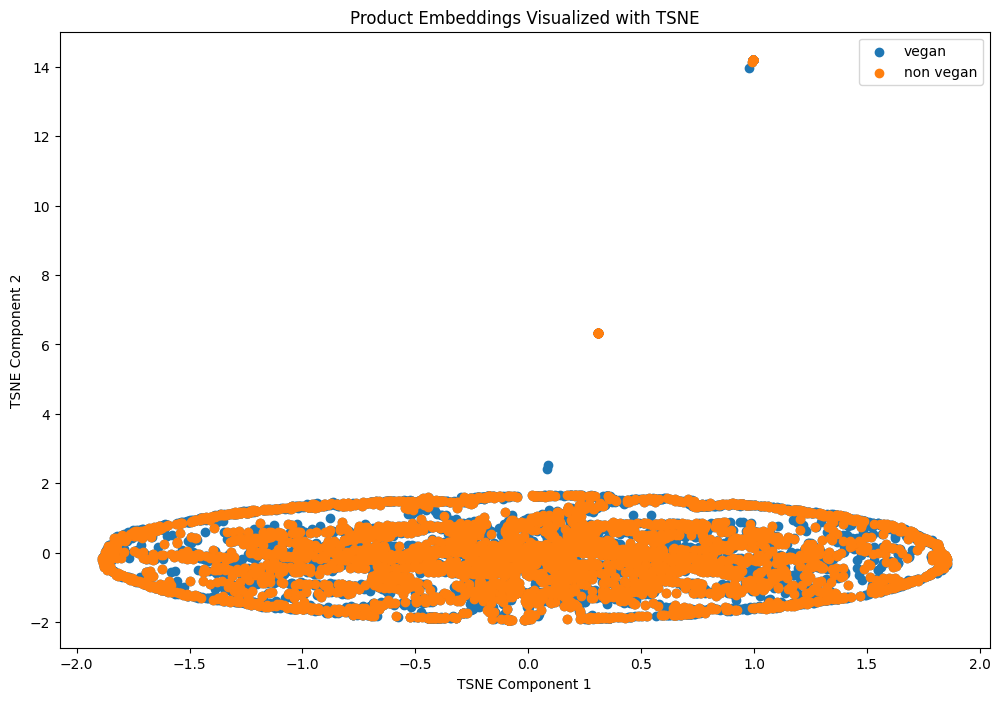

In [67]:
plt.figure(figsize=(12, 8))
for category in tqdm(labels_tags_vegan):
    indices = df[df['clean_labels_tags'].apply(lambda x: category in x)].index
    print(np.std(reduced_embeddings))
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], alpha=1, label=category)

plt.title('Product Embeddings Visualized with TSNE')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.show()

100%|██████████| 2/2 [00:00<00:00, 74.35it/s]


1.1925055
1.1925055


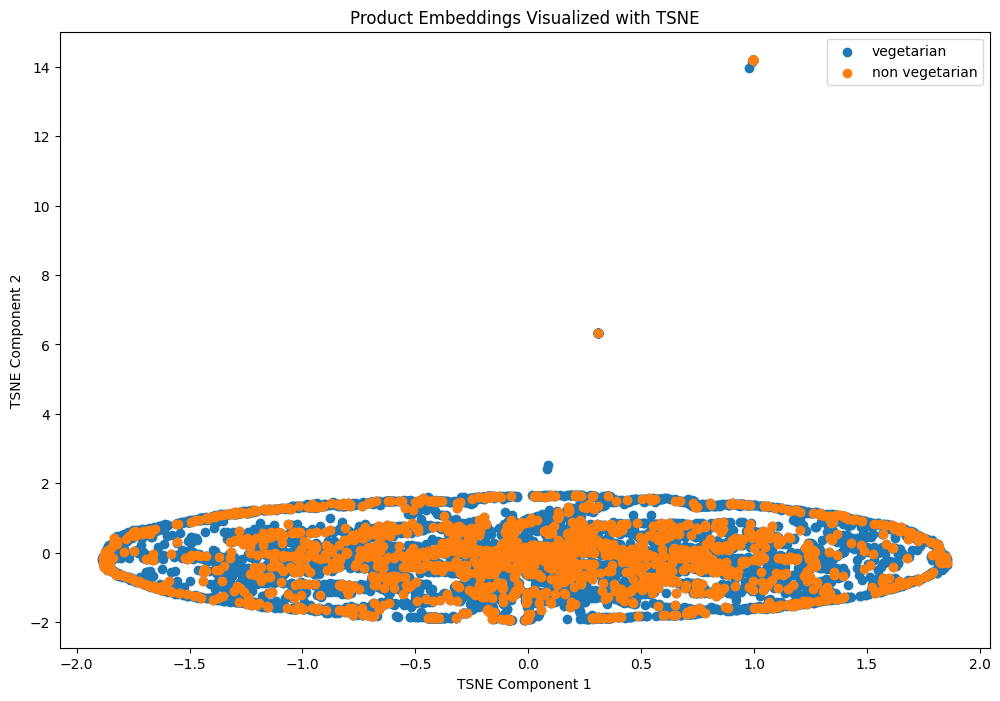

In [68]:
plt.figure(figsize=(12, 8))
for category in tqdm(labels_tags_vegetarian):
    indices = df[df['clean_labels_tags'].apply(lambda x: category in x)].index
    print(np.std(reduced_embeddings))
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], alpha=1, label=category)

plt.title('Product Embeddings Visualized with TSNE')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.show()

#### saving embeddings for tensorboard visualization

In [169]:
import tensorflow as tf
from tensorboard.plugins import projector

In [189]:
vegan_labels = df['Vegan'].apply(lambda x: 'Vegan' if x == 1 else 'Non-Vegan').tolist()
vegetarian_labels = df['Vegetarian'].apply(lambda x: 'Vegetarian' if x == 1 else 'Non-Vegetarian').tolist()

In [199]:
print("Number of embeddings:", len(embedding_matrix))
print("Number of vegan labels:", len(vegan_labels))
print("Number of vegetarian labels:", len(vegetarian_labels))


Number of embeddings: 9436
Number of vegan labels: 9436
Number of vegetarian labels: 9436


In [219]:
log_dir = 'logs/'

embedding_var = tf.Variable(embedding_matrix, name='product_embeddings')

# Create a checkpoint from which TensorBoard will load the embeddings
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up the config for the projector
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path =  'metadata.tsv'  # File to save the labels

with open(f'{log_dir}/{embedding.metadata_path}', 'w') as f:
    f.write("Vegan\tVegetarian\n")

    # Write the labels for each embedding
    for vegan_label, vegetarian_label in zip(vegan_labels, vegetarian_labels):
        f.write(f'{vegan_label}\t{vegetarian_label}\n')


projector.visualize_embeddings(log_dir, config)

In [207]:
! tensorboard --logdir=/Users/steven/Documents/ESILV_A5/Web_scrap/Project/logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### Embeddings visualisation (PCA)

In [69]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA(n_components=2, random_state=1236)
reduced_embeddings = pca.fit_transform(embedding_matrix)

100%|██████████| 2/2 [00:00<00:00, 48.11it/s]


0.17205749992824032
0.17205749992824032


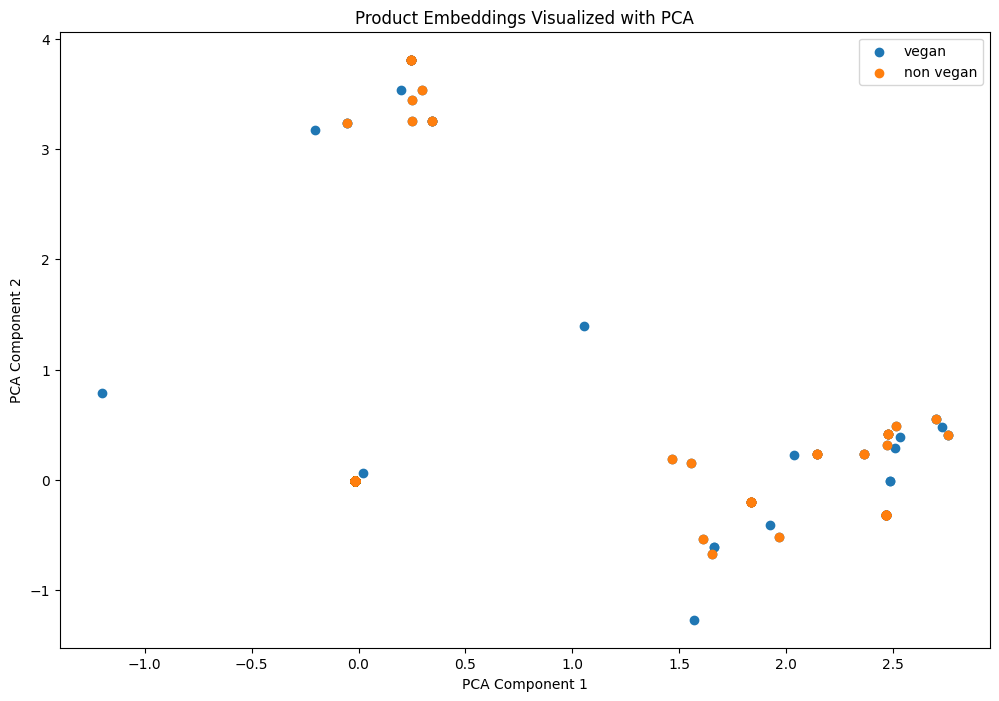

In [71]:
plt.figure(figsize=(12, 8))
for category in tqdm(labels_tags_vegan):
    indices = df[df['clean_labels_tags'].apply(lambda x: category in x)].index
    print(np.std(reduced_embeddings))
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], alpha=1, label=category)

plt.title('Product Embeddings Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

100%|██████████| 2/2 [00:00<00:00, 76.31it/s]


0.17205749992824032
0.17205749992824032


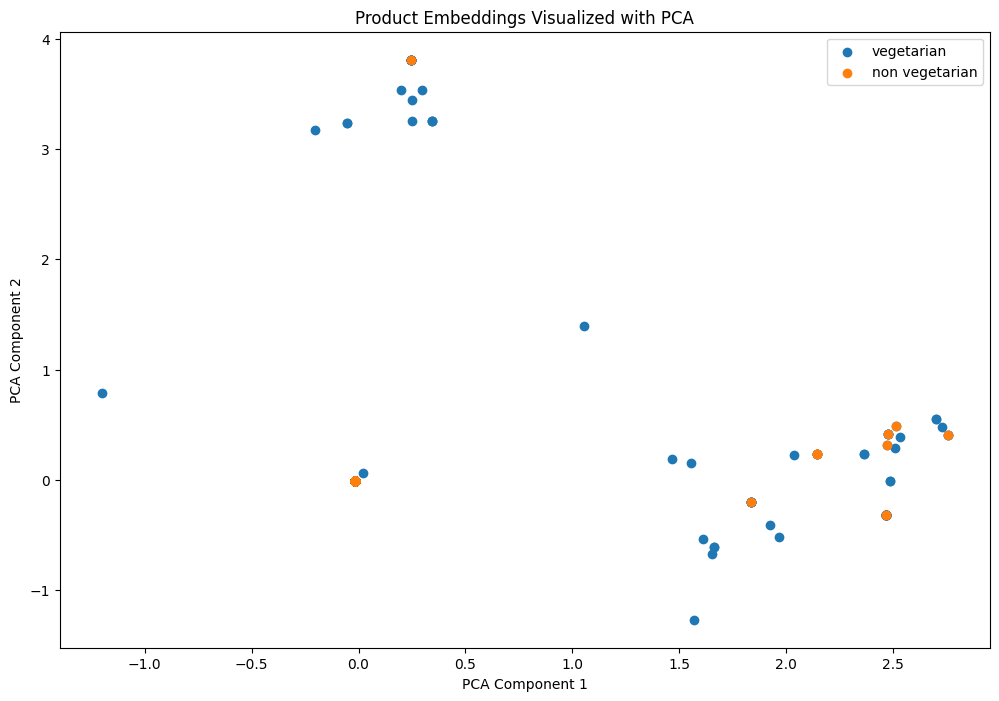

In [72]:
plt.figure(figsize=(12, 8))
for category in tqdm(labels_tags_vegetarian):
    indices = df[df['clean_labels_tags'].apply(lambda x: category in x)].index
    print(np.std(reduced_embeddings))
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], alpha=1, label=category)

plt.title('Product Embeddings Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

Here's the visualization of Word2Vec ingredient embeddings using TSNE reduction. This scatter plot shows how different ingredients are positioned relative to each other in a reduced 2-dimensional space. Each point represents an ingredient, and ingredients that are closer together in this space are more similar in the context of the recipes.

### Interpretation:
- Ingredients clustered together likely share similar contexts in recipes.
- This visualization can help in understanding ingredient relationships and possibly in predicting ingredient substitutions or complementarity.

## ML model to predict missing label tags

In [81]:
# df.to_csv('data.csv', index=False)

In [86]:
df.head()

,id,ingredients_tags,labels_tags,Vegan,Vegetarian,cleaned_ingredients,clean_labels_tags,num_ingredients
0,3274080005003,"['en:spring-water', 'en:water']","['en:palm-oil-free', 'en:vegan', 'en:vegetarian']",1,1,"['spring water', 'water']","[palm oil free, vegan, vegetarian]",2
1,3017620422003,"['en:sugar', 'en:added-sugar', 'en:disaccharid...","['en:palm-oil', 'en:non-vegan', 'en:vegetarian...",0,1,"['sugar', 'added sugar', 'disaccharide', 'palm...","[palm oil, non vegan, vegetarian status unknown]",22
2,7622210449283,"['en:cereal', 'en:sugar', 'en:added-sugar', 'e...","['en:palm-oil', 'en:non-vegan', 'en:vegetarian...",0,1,"['cereal', 'sugar', 'added sugar', 'disacchari...","[palm oil, non vegan, vegetarian status unknown]",35
3,5449000214911,"['en:carbonated-water', 'en:water', 'en:sugar'...","['en:palm-oil-free', 'en:maybe-vegan', 'en:may...",1,1,"['carbonated water', 'water', 'sugar', 'added ...","[palm oil free, maybe vegan, maybe vegetarian]",12
4,3017620425035,"['en:sugar', 'en:added-sugar', 'en:disaccharid...","['en:palm-oil', 'en:non-vegan', 'en:vegetarian...",0,1,"['sugar', 'added sugar', 'disaccharide', 'palm...","[palm oil, non vegan, vegetarian status unknown]",20


In [88]:
vegan_class = ['vegan', 'non vegan']
vegetarian_class = ['vegetarian', 'non vegetarian']

specific_class_df = df[df['clean_labels_tags'].apply(
    lambda x: 
        any(category in x for category in vegan_class) and any(category in x for category in vegetarian_class)
    )]

train_df, test_df = train_test_split(specific_class_df, test_size=0.2, random_state=42)

train_embeddings = np.array(train_df['cleaned_ingredients'].apply(product_embedding).tolist())
test_embeddings = np.array(test_df['cleaned_ingredients'].apply(product_embedding).tolist())

train_df.shape, test_df.shape

((4004, 8), (1002, 8))

### Using topk (50) similarity to compute label tags

#### fully unsupervised

In [100]:
def assign_dual_class_based_on_neighbors_flat_lists(test_embeddings, train_embeddings, train_labels, primary_classes, secondary_classes, k=15):
    """
    Assign a dual class (primary and secondary) to each test product based on the k closest neighbors in the training set.
    This function is designed to handle flat lists (or arrays) of embeddings for efficiency.
    """
    assigned_primary = []
    assigned_secondary = []

    # Iterate over test embeddings
    for test_embedding in tqdm(test_embeddings, desc="Assigning Classes"):
        # Compute cosine similarities between the test product and all train products
        similarities = cosine_similarity([test_embedding], train_embeddings)[0]

        # Get the indices of the k closest neighbors
        neighbors_indices = similarities.argsort()[-k:][::-1]

        # Get the class labels of these neighbors
        neighbor_labels = train_labels.iloc[neighbors_indices]
        flat_neighbor_labels = list(chain.from_iterable(neighbor_labels))

        # Assign primary class (vegan/non-vegan)
        primary_neighbor_labels = [label for label in flat_neighbor_labels if label in primary_classes]
        primary_class = Counter(primary_neighbor_labels).most_common(1)[0][0]

        # Assign secondary class (vegetarian/non-vegetarian)
        secondary_neighbor_labels = [label for label in flat_neighbor_labels if label in secondary_classes]
        secondary_class = Counter(secondary_neighbor_labels).most_common(1)[0][0]

        # Append results
        assigned_primary.append(primary_class)
        assigned_secondary.append(secondary_class)

    return assigned_primary, assigned_secondary


# Define primary and secondary classes
primary_classes = ['vegan', 'non vegan']
secondary_classes = ['vegetarian', 'non vegetarian']

# Now applying the function to the entire test dataset
test_primary, test_secondary = assign_dual_class_based_on_neighbors_flat_lists(
    test_embeddings,
    train_embeddings,
    train_df['clean_labels_tags'],
    primary_classes,
    secondary_classes,
    k=50
)

# Assigning the results back to the test dataframe
test_df['assigned_primary'] = test_primary
test_df['assigned_secondary'] = test_secondary

# Display the first few rows of the test set with the assigned labels
test_df[['clean_labels_tags', 'assigned_primary', 'assigned_secondary']].head()

Assigning Classes: 100%|██████████| 1002/1002 [00:08<00:00, 120.12it/s]


,clean_labels_tags,assigned_primary,assigned_secondary
5265,"[palm oil free, non vegan, non vegetarian]",non vegan,vegetarian
6461,"[palm oil free, vegan, vegetarian]",non vegan,vegetarian
2214,"[palm oil content unknown, non vegan, non vege...",non vegan,vegetarian
4448,"[palm oil free, vegan, vegetarian]",non vegan,vegetarian
7578,"[palm oil free, non vegan, vegetarian]",non vegan,vegetarian


In [101]:
def split_composite_label(label):
    primary = 'non vegan' if 'non vegan' in label else 'vegan'
    secondary = 'non vegetarian' if 'non vegetarian' in label else 'vegetarian'
    return primary, secondary

true_primary, true_secondary = zip(*test_df['clean_labels_tags'].apply(split_composite_label))

# Calculate performance metrics for primary class
primary_accuracy = accuracy_score(true_primary, test_df['assigned_primary'])
primary_precision = precision_score(true_primary, test_df['assigned_primary'], average='weighted')
primary_recall = recall_score(true_primary, test_df['assigned_primary'], average='weighted')
primary_f1 = f1_score(true_primary, test_df['assigned_primary'], average='weighted')

primary_metrics = {
    "Accuracy": primary_accuracy,
    "Precision": primary_precision,
    "Recall": primary_recall,
    "F1 Score": primary_f1
}

primary_metrics

/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.500998003992016,
 'Precision': 0.25099900000398406,
 'Recall': 0.500998003992016,
 'F1 Score': 0.3344428164946702}

In [102]:
# Calculate performance metrics for secondary class
secondary_accuracy = accuracy_score(true_secondary, test_df['assigned_secondary'])
secondary_precision = precision_score(true_secondary, test_df['assigned_secondary'], average='weighted')
secondary_recall = recall_score(true_secondary, test_df['assigned_secondary'], average='weighted')
secondary_f1 = f1_score(true_secondary, test_df['assigned_secondary'], average='weighted')


secondary_metrics = {
    "Accuracy": secondary_accuracy,
    "Precision": secondary_precision,
    "Recall": secondary_recall,
    "F1 Score": secondary_f1
}

secondary_metrics

/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.6287425149700598,
 'Precision': 0.3953171501308759,
 'Recall': 0.6287425149700598,
 'F1 Score': 0.48542620641070794}

#### Semy-supervised

In [106]:
knn_vegan = KNeighborsClassifier(n_neighbors=50)
knn_vegan.fit(train_embeddings, train_df['Vegan'])

knn_vegetarian = KNeighborsClassifier(n_neighbors=50)
knn_vegetarian.fit(train_embeddings, train_df['Vegetarian'])

KNeighborsClassifier(n_neighbors=50)

In [107]:
knn_vegan_predictions = knn_vegan.predict(test_embeddings)

knn_vegetarian_predictions = knn_vegetarian.predict(test_embeddings)

In [108]:
knn_vegan_report = classification_report(test_df['Vegan'], knn_vegan_predictions)
print("KNN Classifier Report:\n", knn_vegan_report)

KNN Classifier Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       502
           1       0.50      1.00      0.67       500

    accuracy                           0.50      1002
   macro avg       0.25      0.50      0.33      1002
weighted avg       0.25      0.50      0.33      1002



/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
knn_vegetarian_report = classification_report(test_df['Vegetarian'], knn_vegetarian_predictions)
print("KNN Classifier Report:\n", knn_vegetarian_report)

KNN Classifier Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       372
           1       0.63      1.00      0.77       630

    accuracy                           0.63      1002
   macro avg       0.31      0.50      0.39      1002
weighted avg       0.40      0.63      0.49      1002



/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/steven/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Prediction using TF IDF and vectorization

In [112]:

# Preprocessing ingredient lists: joining the lists into single strings for each product
train_ingredients_str = ["".join(ing) for ing in train_df['cleaned_ingredients']]
test_ingredients_str = ["".join(ing) for ing in test_df['cleaned_ingredients']]

# Using TF-IDF to create feature vectors
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_ingredients_str)
test_features = vectorizer.transform(test_ingredients_str)

# Checking the shape of the created feature vectors
train_features.shape, test_features.shape

((4004, 3698), (1002, 3698))

In [113]:
rf_vegan = RandomForestClassifier()
rf_vegan.fit(train_features, train_df['Vegan'])

rf_vegetarian = RandomForestClassifier()
rf_vegetarian.fit(train_features, train_df['Vegetarian'])

RandomForestClassifier()

In [114]:
rf_vegan_predictions = rf_vegan.predict(test_features)
rf_vegetarian_predictions = rf_vegetarian.predict(test_features)

In [115]:
rf_report = classification_report(test_df['Vegan'], rf_vegan_predictions)
print("Random Forest Classifier Report:\n", rf_report)

Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       502
           1       0.99      0.97      0.98       500

    accuracy                           0.98      1002
   macro avg       0.98      0.98      0.98      1002
weighted avg       0.98      0.98      0.98      1002



In [116]:
rf_report = classification_report(test_df['Vegetarian'], rf_vegetarian_predictions)
print("Random Forest Classifier Report:\n", rf_report)

Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       372
           1       0.99      0.99      0.99       630

    accuracy                           0.99      1002
   macro avg       0.98      0.99      0.99      1002
weighted avg       0.99      0.99      0.99      1002



#### Lets predict for all the products of the database

In [117]:
# Filter out rows from the original DataFrame
remaining_df = df[~df.index.isin(train_df.index) & ~df.index.isin(test_df.index)]

# Convert ingredient lists to strings
remaining_ingredients_str = [" ".join(ing) for ing in remaining_df['cleaned_ingredients']]

# Apply TF-IDF vectorization
remaining_features = vectorizer.transform(remaining_ingredients_str)

In [118]:
rf_vegan_remaining_predictions = rf_vegan.predict(remaining_features)
rf_vegetarian_remaining_predictions = rf_vegetarian.predict(remaining_features)

In [119]:
# Create a mask for selecting rows not in train_df or test_df
not_in_train_or_test = ~df.index.isin(train_df.index) & ~df.index.isin(test_df.index)

# Assign the predictions to the corresponding columns
df.loc[not_in_train_or_test, 'Vegan'] = rf_vegan_remaining_predictions
df.loc[not_in_train_or_test, 'Vegetarian'] = rf_vegetarian_remaining_predictions

In [120]:
df.to_csv('/data/all_veg_data.csv', index=False)

#### Let's retry some visualisation

In [154]:
def product_vectorize_embedding(ingredients):
    valid_ingredients = ["".join(ast.literal_eval(ingredient)) for ingredient in ingredients]
    return vectorizer.transform(valid_ingredients)

product_embeddings = product_vectorize_embedding(df["cleaned_ingredients"])

In [158]:
np.shape(product_embeddings)

(9436, 3698)

In [212]:
type(product_embeddings.tolist())

list

In [222]:
log_dir = 'logs_tfidf/'

embedding_var = tf.Variable(np.array(product_embeddings.tolist()), name='product_embeddings')

# Create a checkpoint from which TensorBoard will load the embeddings
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up the config for the projector
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path =  'metadata.tsv'  # File to save the labels


with open(f'{log_dir}/{embedding.metadata_path}', 'w') as f:
    f.write("Vegan\tVegetarian\n")

    # Write the labels for each embedding
    for vegan_label, vegetarian_label in zip(vegan_labels, vegetarian_labels):
        f.write(f'{vegan_label}\t{vegetarian_label}\n')


projector.visualize_embeddings(log_dir, config)

In [224]:
! tensorboard --logdir=/Users/steven/Documents/ESILV_A5/Web_scrap/Project/logs_tfidf

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.1 at http://localhost:6006/ (Press CTRL+C to quit)


## Save data on JSON for interface

In [171]:
df = pd.read_csv('data/all_veg_data.csv')

In [172]:
df.head()

,id,ingredients_tags,labels_tags,Vegan,Vegetarian,cleaned_ingredients,clean_labels_tags,num_ingredients
0,3274080005003,"['en:spring-water', 'en:water']","['en:palm-oil-free', 'en:vegan', 'en:vegetarian']",1,1,"['spring water', 'water']","['palm oil free', 'vegan', 'vegetarian']",2
1,3017620422003,"['en:sugar', 'en:added-sugar', 'en:disaccharid...","['en:palm-oil', 'en:non-vegan', 'en:vegetarian...",1,1,"['sugar', 'added sugar', 'disaccharide', 'palm...","['palm oil', 'non vegan', 'vegetarian status u...",22
2,7622210449283,"['en:cereal', 'en:sugar', 'en:added-sugar', 'e...","['en:palm-oil', 'en:non-vegan', 'en:vegetarian...",1,1,"['cereal', 'sugar', 'added sugar', 'disacchari...","['palm oil', 'non vegan', 'vegetarian status u...",35
3,5449000214911,"['en:carbonated-water', 'en:water', 'en:sugar'...","['en:palm-oil-free', 'en:maybe-vegan', 'en:may...",1,1,"['carbonated water', 'water', 'sugar', 'added ...","['palm oil free', 'maybe vegan', 'maybe vegeta...",12
4,3017620425035,"['en:sugar', 'en:added-sugar', 'en:disaccharid...","['en:palm-oil', 'en:non-vegan', 'en:vegetarian...",1,1,"['sugar', 'added sugar', 'disaccharide', 'palm...","['palm oil', 'non vegan', 'vegetarian status u...",20


In [174]:
# Step 1: Filter Labels
allowed_labels = {
    'may contain-palm-oil',
    'palm oil',
    'palm oil content-unknown',
    'palm oil free',
}

# Updating labels_tags column by keeping only allowed labels
df['clean_labels_tags'] = df['clean_labels_tags'].apply(lambda tags: [tag for tag in tags if tag and tag in allowed_labels] if tags is list() else [''])

# Step 2: Update Labels Based on Vegan and Vegetarian Columns
df['clean_labels_tags'] = df.apply(lambda row: row['clean_labels_tags'] + 
                             (['vegan'] if row['Vegan'] == 1 else ['non vegan']) + 
                             (['vegetarian'] if row['Vegetarian'] == 1 else ['non vegetarian']), axis=1)

In [183]:
f = open('data/final_extracted_products.json')
json_data = json.load(f)

In [186]:
copy_json_data = json_data.copy()

In [187]:
for product_id, product_data in tqdm(json_data.items()):
    try:
        corresponding_row = df[df['id'] == int(product_id)].iloc[0]
    except Exception:
        del copy_json_data[product_id]
        continue
    copy_json_data['ingredients_analysis_tags'] = corresponding_row['clean_labels_tags']
    copy_json_data['ingredients_tags'] = corresponding_row['cleaned_ingredients']

# Step 3: Write the Updated JSON Data Back to a File
with open('final_extracted_products.json', 'w') as file:
    json.dump(json_data, file)

100%|██████████| 9951/9951 [00:01<00:00, 4996.69it/s]


In [188]:
with open('final_extracted_products.json', 'w') as file:
    json.dump(copy_json_data, file)